## Basic Multi AI Agent Architecture

In [1]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

### state

In [2]:


class AgentState(TypedDict):
    messages: List[BaseMessage]
    next_agent : str 




### tools

In [3]:
# Create simple tools
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Using Tavily for web search
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content: str) -> str:
    """Write a summary of the provided content."""
    # Simple summary generation
    summary = f"Summary of findings:\n\n{content[:500]}..."
    return summary

In [4]:
llm =ChatGroq(model="openai/gpt-oss-20b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B83166E270>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B83166EF90>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

### Agents 

In [5]:
# Define agent functions (simpler approach)
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    
    messages = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)
    
    # Return the response and route to writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [6]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    
    messages = state["messages"]
    
    # Add system message
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [7]:
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state

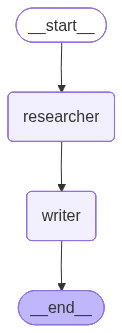

In [8]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [18]:
user_message = input("Enter your question: ")

response=final_workflow.invoke({"messages":user_message})
response["messages"][-1].content

for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

Research about asia cup winner over the 10 years
================================== Ai Message ==================================
Tool Calls:
  search_web (fc_ab89c7cf-cc4e-4d19-a707-e6f9b10406ab)
 Call ID: fc_ab89c7cf-cc4e-4d19-a707-e6f9b10406ab
  Args:
    query: Asia Cup cricket winners 2014 2016 2018 2020 2022
================================== Ai Message ==================================

**Asia Cup – Cricket (Last 10 Years, 2012 – 2022)**  
*(Note: The 2020 edition was postponed by COVID‑19 and actually played in 2023, but the tournament is officially listed as the 2020 Asia Cup.)*

| Year | Host(s) | Final Match | Winner | Final Score (Runs) | Key Player(s) |
|------|---------|-------------|--------|--------------------|---------------|
| 2012 | Bangladesh | India vs. Pakistan | **India** | 241/6 (20 overs) – 227/9 (20 overs) | *Virat Kohli* (73), *Shikhar Dhawan* (86), *Jasprit Bumrah* (3/9) |
| 